# Step 2 Blob extraction (Sunflower)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import keras
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
from google.colab.patches import cv2_imshow
from PIL import Image
import cv2
import os

In [ ]:
# masks
path_annote = './drive/MyDrive/STAT841_final_proj_dataset/annotation'
path_pre = './drive/MyDrive/STAT841_final_proj_dataset/pred_output_512'
path_rgb = './drive/MyDrive/STAT841_final_proj_dataset/RGB'
path_step3 = './drive/MyDrive/STAT841_final_proj_dataset/ready_for_step3'

# image size after prediction in the first setp
img_size = 512
# to save the blob extracted and labeled
crop_label=[]
ind = 0

for img in os.listdir(path_annote):
    i = 0
    ind = ind+1
    if ind%100==0: print(ind)
    img_arr = Image.open(os.path.join(path_annote, img))
    img_arr = img_arr.resize((img_size,img_size))
    img_arr = np.array(img_arr)
    image = Image.open(os.path.join(path_rgb, img))
    image = image.resize((img_size,img_size))
    resized_arr = cv2.imread(os.path.join(path_pre, img))

    # ready to extract rectangle blobs
    img1 = resized_arr
    gray = cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)

    # threshold
    thresh = cv2.threshold(gray,128,255,cv2.THRESH_BINARY)[1]

    
    # get contours
    result = img1.copy()
    contours = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0] if len(contours) == 2 else contours[1]
    for cntr in contours:
        i=i+1
        x,y,w,h = cv2.boundingRect(cntr)
        cv2.rectangle(result, (x, y), (x+w, y+h), (0, 0, 255), 1)
        b,g,r = np.sum(np.sum(img_arr[y:(y+h), x:(x+w), :],axis=1),axis=0)
        label = "crop" if g>b else "weed"
        filename = img.split(".")[0]+"_"+str(i)+".png"
        # filter some possible weeds or stone predicted in step1
        if w*h >= (pow(0.02,2)*pow(img_size,2)): crop_label.append([filename,x,y,w,h,label])

100
200
300
400
500


In [ ]:
df = pd.DataFrame(crop_label, columns=["filename", "x", "y", "w", "h", "label"])
print(df)
df.to_csv('./drive/MyDrive/STAT841_final_proj_dataset/sunflower_label.csv', index=False)

                                    filename    x    y   w    h label
0      jesi_05_12__0_4min_rid_frame112_6.png  198  180  23   22  weed
1      jesi_05_12__0_4min_rid_frame112_7.png  394  127   8   21  weed
2      jesi_05_12__0_4min_rid_frame170_6.png  437  448  11   19  weed
3      jesi_05_12__0_4min_rid_frame170_8.png  390  442  19    8  weed
4     jesi_05_12__0_4min_rid_frame170_11.png  264  426  13   24  weed
...                                      ...  ...  ...  ..  ...   ...
4038                  reduced2_frame86_6.png   60  235  32   31  weed
4039                 reduced2_frame86_10.png  501   15  10   17  weed
4040                 reduced2_frame86_11.png  144    5  46   52  weed
4041                   reduced2_frame6_6.png  263  170  89  102  crop
4042                   reduced2_frame6_8.png  347   42  12   16  weed

[4043 rows x 6 columns]


# Step 3 Prediction


In [ ]:
path_step3 = './drive/MyDrive/STAT841_final_proj_dataset/ready_for_step3'
# image size after prediction in the first setp
img_size_new = 64
ind = 0
sunflower_label = pd.read_csv('./drive/MyDrive/STAT841_final_proj_dataset/sunflower_label.csv')
# print(sunflower_label.filename)
data = []

for img in sunflower_label.filename:
    i = 0
    ind = ind+1
    if ind%1000==0: print(ind)
  
    img_arr = Image.open(os.path.join(path_step3, img))
    img_arr = img_arr.resize((img_size_new,img_size_new))
    img_arr = np.array(img_arr)
    data.append(img_arr)

1000
2000
3000
4000


In [ ]:
x_train =  np.array(data)
# normalize the training dataset
x_train = x_train/255
y_train = []

for label in sunflower_label.label:
    if label=="crop": y_train.append(1)
    else: y_train.append(0)
# our training dataset is imbalanced, 'weed':'crop' is more than 10 times
# level up the thrshold for cropping, ratio increases to almost 20%

y_train = np.array(y_train)

In [ ]:
# Split training and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_train, y_train, test_size = 0.2, random_state = 841)

In [ ]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (img_size_new,img_size_new,3)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 dropout (Dropout)           (None, 32, 32, 64)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 64)       2

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [ ]:
history = model.fit(X_train,y_train, batch_size = 20, epochs = 20, validation_split = 0.2 ,callbacks = [learning_rate_reduction])

Epoch 1/20
130/130 [==============================] - 12s 72ms/step - loss: 0.4530 - accuracy: 0.8384 - val_loss: 1.9807 - val_accuracy: 0.8145 - lr: 0.0010
Epoch 2/20
130/130 [==============================] - 6s 46ms/step - loss: 0.2920 - accuracy: 0.8867 - val_loss: 2.0359 - val_accuracy: 0.8145 - lr: 0.0010
Epoch 3/20
128/130 [============================>.] - ETA: 0s - loss: 0.2248 - accuracy: 0.9129
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
130/130 [==============================] - 5s 37ms/step - loss: 0.2232 - accuracy: 0.9138 - val_loss: 0.5011 - val_accuracy: 0.7697 - lr: 0.0010
Epoch 4/20
130/130 [==============================] - 6s 43ms/step - loss: 0.1454 - accuracy: 0.9474 - val_loss: 0.2115 - val_accuracy: 0.9104 - lr: 3.0000e-04
Epoch 5/20
130/130 [==============================] - 5s 39ms/step - loss: 0.1024 - accuracy: 0.9683 - val_loss: 0.2443 - val_accuracy: 0.9088 - lr: 3.0000e-04
Epoch 6/20
130/130 [==========================

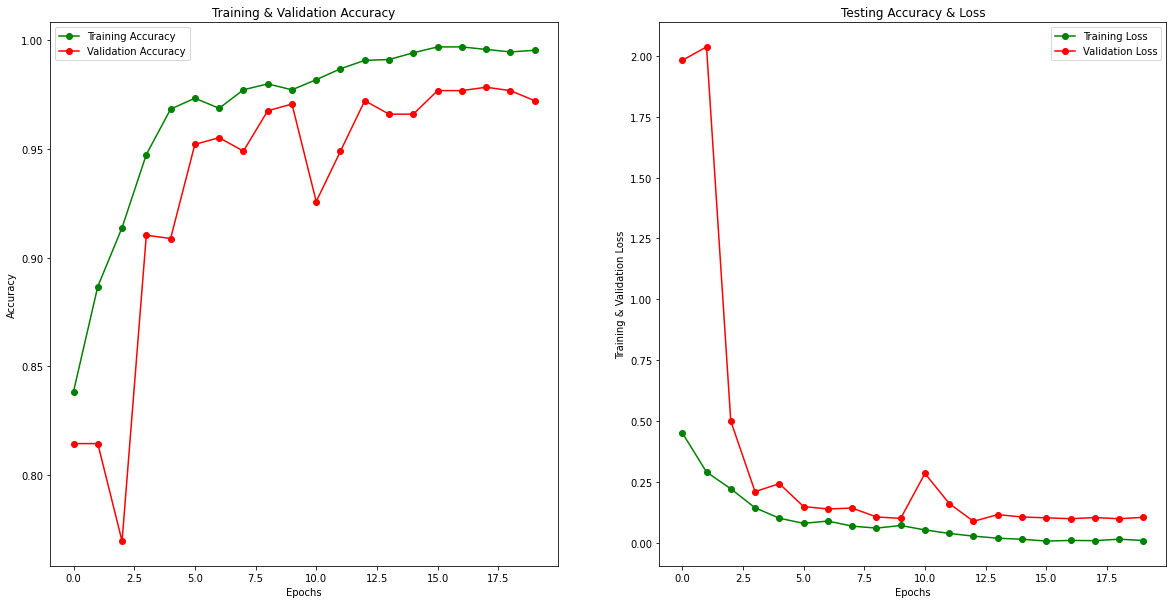

In [ ]:
epochs = [i for i in range(20)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [ ]:
predict_x=model.predict(X_test)
predict_x_class = []
for test in predict_x:
  predict_x_class.append(1) if test>=0.5 else predict_x_class.append(0)

In [ ]:
accuracy = 1-np.mean(y_test!= predict_x_class)
print(accuracy)

0.9876390605686032


# Plot for illustration: blob extraction

x,y,w,h: 344 485 1 2
x,y,w,h: 307 405 5 7
x,y,w,h: 198 389 3 1
x,y,w,h: 298 381 1 1
x,y,w,h: 295 381 2 1
x,y,w,h: 282 381 1 1
x,y,w,h: 282 379 1 1
x,y,w,h: 165 369 186 143
x,y,w,h: 322 281 58 61
x,y,w,h: 359 259 1 1
x,y,w,h: 302 238 68 46
x,y,w,h: 487 198 2 3
x,y,w,h: 491 125 3 3
x,y,w,h: 491 119 3 5
x,y,w,h: 346 111 8 10
x,y,w,h: 244 109 1 1
x,y,w,h: 493 107 5 7
x,y,w,h: 227 35 160 189
x,y,w,h: 20 29 4 9


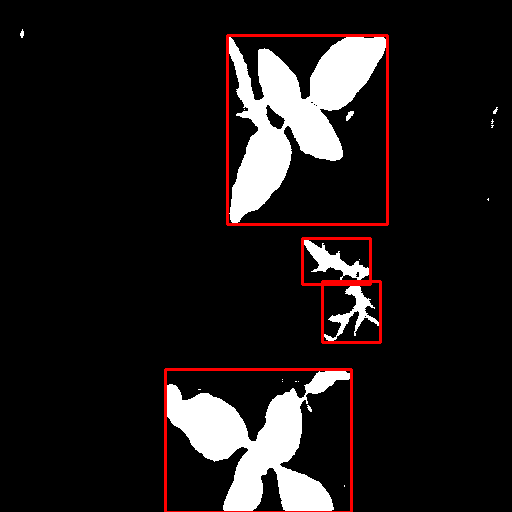

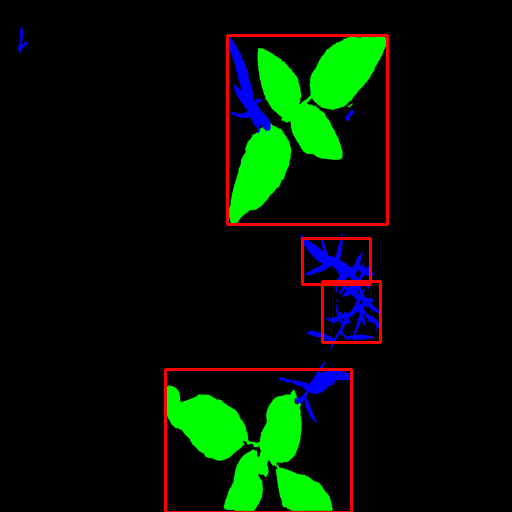

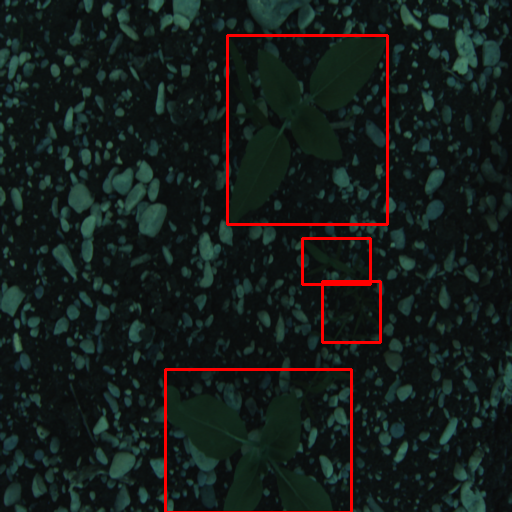

In [ ]:
# find bonding boxes using the interior functions from cv2 of binary pixel graphs
# masks
path_annote = './drive/MyDrive/STAT841_final_proj_dataset/annotation'
path_pre = './drive/MyDrive/STAT841_final_proj_dataset/pred_output_512'
path_rgb = './drive/MyDrive/STAT841_final_proj_dataset/RGB'
path_step3 = './drive/MyDrive/STAT841_final_proj_dataset/ready_for_step3'

# image size after prediction in the first setp
img_size = 512
# to save the blob extracted and labeled
crop_label=[]
# ind = 0

for img in os.listdir(path_annote):
    # i = 0
    # ind = ind+1
    # if ind%100==0: print(ind)
    # img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
    # read in the annotated images and resize them 
    img="reduced0_frame304.png"
    img_arr = Image.open(os.path.join(path_annote, img))
    img_arr = img_arr.resize((img_size,img_size))
    img_arr = np.array(img_arr)
    # resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
    image = Image.open(os.path.join(path_rgb, img))
    image = image.resize((img_size,img_size))
    image = np.array(image)
    # read in the predicted binary mask images
    resized_arr = cv2.imread(os.path.join(path_pre, img))

# read image
    img1 = resized_arr
    gray = cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)

# # threshold
    thresh = cv2.threshold(gray,128,255,cv2.THRESH_BINARY)[1]

    result = img1.copy()
    result1 = img_arr.copy()
    result2 = image.copy()
    contours = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0] if len(contours) == 2 else contours[1]
    for cntr in contours:
        x,y,w,h = cv2.boundingRect(cntr)
        if w*h >= (pow(0.02,2)*pow(img_size,2)): cv2.rectangle(result, (x, y), (x+w, y+h), (0, 0, 255), 2)
        if w*h >= (pow(0.02,2)*pow(img_size,2)): cv2.rectangle(result1, (x, y), (x+w, y+h), (0, 0, 255), 2)
        if w*h >= (pow(0.02,2)*pow(img_size,2)): cv2.rectangle(result2, (x, y), (x+w, y+h), (0, 0, 255), 2)
        # b,g,r = np.sum(np.sum(img_arr[y:(y+h), x:(x+w), :],axis=1),axis=0)
        # label = "crop" if g>r else "weed"
        # crop_label.append([os.path.join(img), x,y,w,h,label])
        print("x,y,w,h:",x,y,w,h)
    cv2_imshow(result)
    cv2_imshow(result1)
    cv2_imshow(result2)
    break


In [ ]:
# masks
path_annote = './drive/MyDrive/dataset-1.0/annotations'
path_pre = './drive/MyDrive/dataset-1.0/pred_output_512'
path_rgb = './drive/MyDrive/dataset-1.0/images'
path_step3 = './drive/MyDrive/dataset-1.0/ready_for_step3'

# image size after prediction in the first setp
img_size = 512
# to save the blob extracted and labeled
crop_label=[]


for img in os.listdir(path_rgb):
    img_annote = img.split("_")[0]+"_annotation.png"
    img_arr = Image.open(os.path.join(path_annote, img_annote))
    img_arr = img_arr.resize((img_size,img_size))
    img_arr = np.array(img_arr)
    # resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
    image = Image.open(os.path.join(path_rgb, img))
    image = image.resize((img_size,img_size))
    resized_arr = cv2.imread(os.path.join(path_pre, img))

    # ready to extract rectangle blobs
    img1 = resized_arr
    gray = cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)


    # threshold
    thresh = cv2.threshold(gray,128,255,cv2.THRESH_BINARY)[1]

    
    # get contours
    result = img1.copy()
    contours = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0] if len(contours) == 2 else contours[1]
    for cntr in contours:
        # i=i+1
        x,y,w,h = cv2.boundingRect(cntr)
        cv2.rectangle(result, (x, y), (x+w, y+h), (0, 0, 255), 1)
        b,g,r = np.sum(np.sum(img_arr[y:(y+h), x:(x+w), :],axis=1),axis=0)
        label = "crop" if g>b else "weed"
        filename = img.split(".")[0]+"_"+str(i)+".png"
        # filter some possible weeds or stone predicted in step1
        if w*h >= (pow(0.02,2)*pow(img_size,2)): crop_label.append([filename,x,y,w,h,label])
        box = (x, y, x+w, y+h)
        cropped_image = image.crop(box)
        # cropped_image = np.array(cropped_image)
        # cropped_image.show()
        # print("x,y,w,h:",x,y,w,h)
        cropped_image.save(os.path.join(path_step3,filename))
        cropped_image.save(filename)

In [ ]:
df = pd.DataFrame(crop_label, columns=["filename", "x", "y", "w", "h", "label"])
print(df)
df.to_csv('./drive/MyDrive/dataset-1.0/carrot_label.csv', index=False)

            filename    x    y    w    h label
0    034_image_0.png  376  504   14    8  weed
1    034_image_0.png  309  434   16   18  weed
2    034_image_0.png  281  426   17   26  weed
3    034_image_0.png  338  410   14   21  crop
4    034_image_0.png  364  265   11   17  weed
..               ...  ...  ...  ...  ...   ...
255  038_image_0.png  335  249   20   19  weed
256  038_image_0.png  320  197   20   15  weed
257  038_image_0.png  293  182   14    9  crop
258  038_image_0.png    0    0  512  512  weed
259  047_image_0.png    0    0  512  512  weed

[260 rows x 6 columns]


In [ ]:
path_step3 = './drive/MyDrive/dataset-1.0/ready_for_step3'
# image size after prediction in the first setp
img_size_new = 64
ind = 0
carrot_label = pd.read_csv('./drive/MyDrive/dataset-1.0/carrot_label.csv')
# print(sunflower_label.filename)
data = []

for img in carrot_label.filename:
  
    img_arr = Image.open(os.path.join(path_step3, img))
    img_arr = img_arr.resize((img_size_new,img_size_new))
    img_arr = np.array(img_arr)
    data.append(img_arr)

In [ ]:
x_train = []
x_train =  np.array(data)
# normalize the training dataset
x_train = x_train/255
y_train = []

for label in carrot_label.label:
    if label=="crop": y_train.append(1)
    else: y_train.append(0)
# our training dataset is imbalanced, 'weed':'crop' is more than 10 times
# level up the thrshold for cropping, ratio increases to almost 20%

y_train = np.array(y_train)

In [ ]:
# Split training and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_train, y_train, test_size = 0.2, random_state = 841)

In [ ]:
history = model.fit(X_train,y_train, batch_size = 10, epochs = 30, validation_split = 0.2 ,callbacks = [learning_rate_reduction])

Epoch 1/30
17/17 [==============================] - 1s 69ms/step - loss: 0.4744 - accuracy: 0.7470 - val_loss: 0.5833 - val_accuracy: 0.6429 - lr: 1.0000e-06
Epoch 2/30
17/17 [==============================] - 0s 21ms/step - loss: 0.4723 - accuracy: 0.7892 - val_loss: 0.5807 - val_accuracy: 0.7381 - lr: 1.0000e-06
Epoch 3/30
17/17 [==============================] - 0s 23ms/step - loss: 0.4423 - accuracy: 0.7771 - val_loss: 0.5787 - val_accuracy: 0.7381 - lr: 1.0000e-06
Epoch 4/30
17/17 [==============================] - 0s 21ms/step - loss: 0.4761 - accuracy: 0.7590 - val_loss: 0.5765 - val_accuracy: 0.7381 - lr: 1.0000e-06
Epoch 5/30
17/17 [==============================] - 2s 125ms/step - loss: 0.4901 - accuracy: 0.7590 - val_loss: 0.5747 - val_accuracy: 0.7381 - lr: 1.0000e-06
Epoch 6/30
17/17 [==============================] - 0s 22ms/step - loss: 0.4805 - accuracy: 0.7651 - val_loss: 0.5724 - val_accuracy: 0.7381 - lr: 1.0000e-06
Epoch 7/30
17/17 [==============================] -

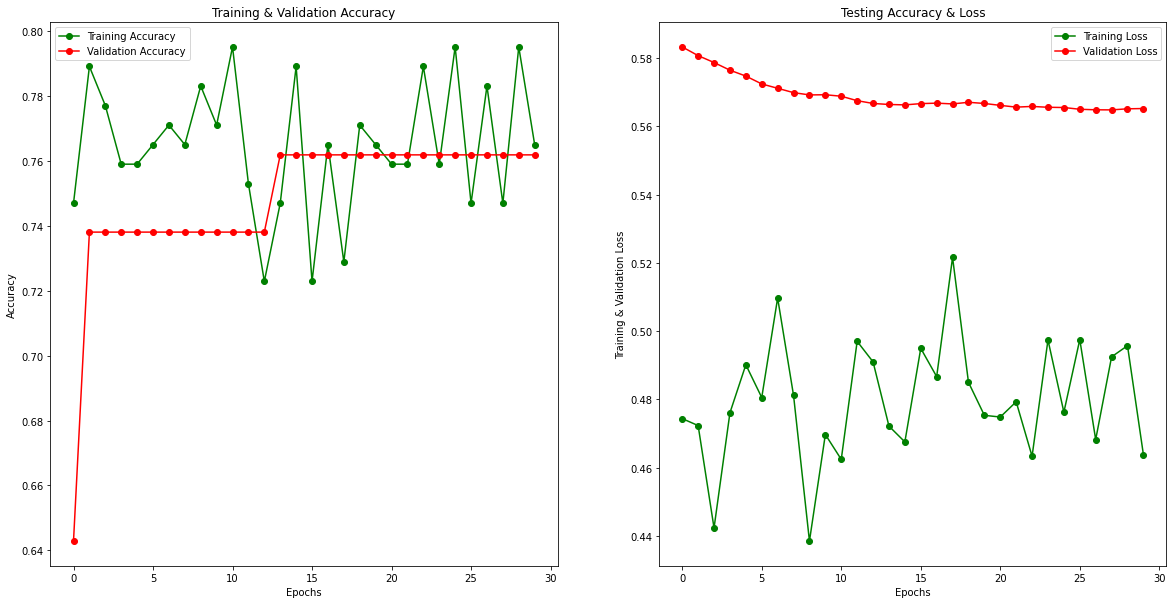

In [ ]:
epochs = [i for i in range(30)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [ ]:
predict_x=model.predict(X_test)
predict_x_class = []
for test in predict_x:
  predict_x_class.append(1) if test>=0.5 else predict_x_class.append(0)

In [ ]:
accuracy = 1-np.mean(y_test!= predict_x_class)
print(accuracy)

0.6153846153846154
